In [99]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as PDEModel

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation


#Plotting tools
import matplotlib.pyplot as plt
import numpy.random as rd


In [100]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,5) # lower time
xloc=np.linspace(1,9,4) # x locations
yloc=np.linspace(1,9,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

XGP= np.zeros((sensN*obsN,3))
XGP[:,0] = (X[:,0]+X[:,1])/2
XGP[:,1] = X[:,2]
XGP[:,2] = X[:,3] 

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [256]:
np.random.seed(124)
k_0 = 1 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=100 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[50,10,10])# corners of the grid - in units of space
k = EQ(2, 1.0) # generate EQ kernel arguments are lengthscale and variance
res = [5000,50,50] # grid size for time, x and y


u1 = -0.5
u2 = -0.5
windmodel=WindSimple(u1,u2) # establish fixed wind model

#wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
#u=[]
#u.append(np.ones(res)*wind) #x direction wind
#u.append(np.ones(res)*0.0) # y direction wind
#windmodel=WindFixU(u)

m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [257]:
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrainNoise= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

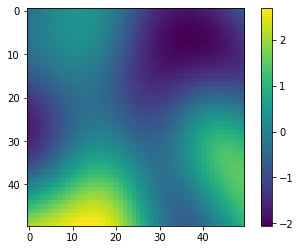

In [275]:
plt.imshow(sourceGT[4999])
plt.colorbar()

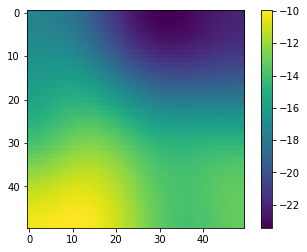

In [274]:
plt.imshow(concTrain[4999])
plt.colorbar()

In [260]:
X.shape

(80, 4)

In [261]:
yTrain.shape

(80,)

In [262]:
FullObs = np.hstack((X,yTrain[:,None]))
FullObsNoise = np.hstack((X,yTrainNoise[:,None]))

In [263]:
FullObs

array([[ 1.00000000e+00,  1.10000000e+00,  1.00000000e+00,
         1.00000000e+00, -2.95337148e-01],
       [ 1.00000000e+00,  1.10000000e+00,  1.00000000e+00,
         3.66666667e+00, -1.55303235e+00],
       [ 1.00000000e+00,  1.10000000e+00,  1.00000000e+00,
         6.33333333e+00, -6.76579074e-01],
       [ 1.00000000e+00,  1.10000000e+00,  1.00000000e+00,
         9.00000000e+00, -3.78253211e-03],
       [ 3.00000000e+00,  3.10000000e+00,  1.00000000e+00,
         1.00000000e+00, -6.58735867e-01],
       [ 3.00000000e+00,  3.10000000e+00,  1.00000000e+00,
         3.66666667e+00, -2.68667709e+00],
       [ 3.00000000e+00,  3.10000000e+00,  1.00000000e+00,
         6.33333333e+00,  4.28284694e-01],
       [ 3.00000000e+00,  3.10000000e+00,  1.00000000e+00,
         9.00000000e+00,  1.35903095e+00],
       [ 5.00000000e+00,  5.10000000e+00,  1.00000000e+00,
         1.00000000e+00,  2.48935195e-01],
       [ 5.00000000e+00,  5.10000000e+00,  1.00000000e+00,
         3.66666667e+00

In [264]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(2, 1.0) 
k2 = EQ(2, 1.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concInfer = mPDE.computeResponse(sourceInfer)
yOut = mPDE.computeObservations()



Computing SS...
Inverting SS...
Computing meanZ
Done


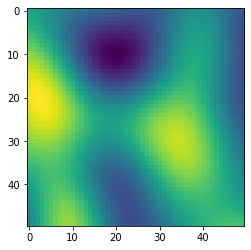

In [265]:
plt.imshow(sourceInfer[9])

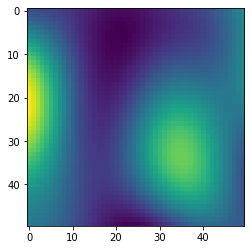

In [266]:
plt.imshow(sourceGT[9])

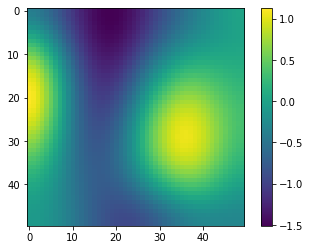

In [273]:
plt.imshow(concTrain[99])
plt.colorbar()

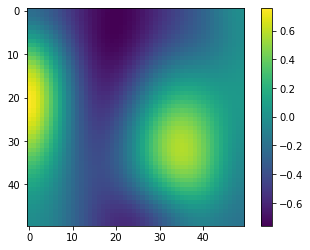

In [268]:
plt.imshow(concTrain[49])
plt.colorbar()

In [269]:
#plt.imshow(sourceFromCSV[9])

In [270]:
np.mean((sourceGT-sourceInfer)**2)


2.1287797347891844

In [271]:
np.mean((concTrain-concInfer)**2)

82.28743928795141

In [142]:
import csv
np.savetxt("Observations16Sens5Timesa1b05.csv", FullObs, delimiter=",")
np.savetxt("Observations16Sens5Timesa1b05Noise.csv", FullObsNoise, delimiter=",")
np.savetxt("GroundTruthSource16Sens5Timesa1b05.csv", np.reshape(sourceGT,(res[0],res[1]*res[2])), delimiter=",")
np.savetxt("GroundTruthConc16Sens5Timesa1b05.csv", np.reshape(concTrain,(res[0],res[1]*res[2])), delimiter=",")

In [143]:
sourceFromCSV=np.genfromtxt("GroundTruthSource16Sens5Times.csv",delimiter=',')
sourceFromCSV=np.reshape(sourceFromCSV,(50,50,50))

# GP Comparison

In [144]:
import GPy

In [145]:
sensWindX = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[0]).shape)
sensWindY = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[1]).shape)
xwind=np.asarray(m.u).take(sensWindX)
ywind=np.asarray(m.u).take(sensWindY)

XGPwind = np.c_[XGP,xwind,ywind]

In [146]:
kGP = GPy.kern.RBF(3, name="rbf")

In [147]:
mGP = GPy.models.GPRegression(XGP, yTrain[:,None], kGP)
mGP 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [148]:
mGP.optimize()
mGP

GP_regression.,value,constraints,priors
rbf.variance,18.282955100842628,+ve,
rbf.lengthscale,2.9507174223976613,+ve,
Gaussian_noise.variance,1.7592631718131264e-07,+ve,


In [149]:
kGPwind = GPy.kern.RBF(5,ARD='true')
mGPwind = GPy.models.GPRegression(XGPwind, yTrain[:,None], kGPwind)
mGPwind 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [150]:
mGPwind.optimize()
mGPwind

GP_regression.,value,constraints,priors
rbf.variance,10.033508348581089,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,3.2465138987491824e-10,+ve,


In [154]:
meanGP, Cov = mGP.predict_noiseless(m.coords.transpose().reshape(50*50*200,3), full_cov=False)
meanGP=meanGP.reshape(50,50,200).T

In [155]:
concTrain.shape

(200, 50, 50)

In [156]:
np.mean((meanGP-concTrain)**2)

0.3179190802366853

In [157]:
np.mean((concInfer-concTrain)**2)

1.4292835247864892

In [68]:
GPWindTest=np.c_[mPDE.coords.transpose().reshape(1000*50*50,3),mPDE.u[0].flatten(),mPDE.u[1].flatten()]

In [71]:
meanGPWind, CovWind = mGPwind.predict_noiseless(GPWindTest, full_cov=False)
meanGPWind=meanGPWind.reshape(50,50,1000).T

In [72]:
np.mean((meanGPWind-concTrain)**2)

0.03658151878964129

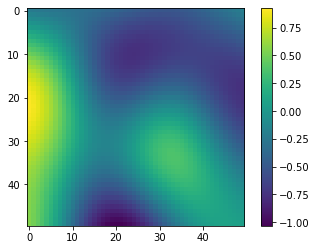

In [73]:
plt.imshow(meanGPWind[10])
plt.colorbar()

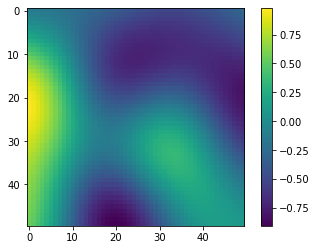

In [74]:
plt.imshow(meanGP[10])
plt.colorbar()

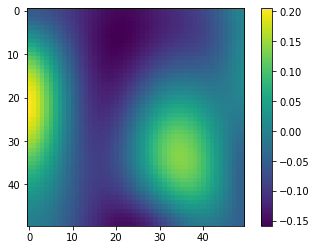

In [77]:
plt.imshow(concTrain[10])
plt.colorbar()

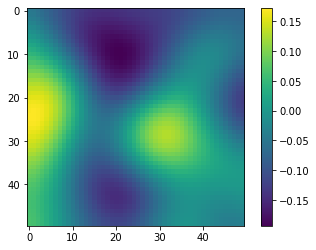

In [78]:
plt.imshow(concInfer[10])
plt.colorbar()

In [ ]:
SourceCoords = np.c_[m.coords.transpose().reshape(1000*50*50,3),sourceGT.transpose().flatten()]

In [ ]:
ConcCoords = np.c_[m.coords.transpose().reshape(1000*50*50,3),concTrain.transpose().flatten()]

In [ ]:
ConcCoords

In [ ]:
concTrain[48,49,49]

In [ ]:
concTrain[m.getGridCoord(XGP)].shape

In [ ]:
ravel = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(concTrain).shape)

Data=np.asarray(concTrain).take(ravel)
noiseData = Data + np.random.normal(0,noiseSD,80)

exactData =  np.c_[XGP,Data]
noisyData = np.c_[XGP,noiseData]
testData = np.c_[m.getGridCoord(XGP),Data]

In [ ]:
np.savetxt("exactObservationsPDEa1b05", exactData, delimiter=",")
np.savetxt("noisyObservationsPDEa1b05", noisyData, delimiter=",")
np.savetxt("GroundTruthSourceCoordsPDEa1b05", SourceCoords, delimiter=",")
np.savetxt("GroundTruthConcCoordsPDEa1b05",ConcCoords, delimiter=",")

In [ ]:
exactData[3]

In [ ]:
noisyData[3]

In [ ]:
testData[0]

In [ ]:
concTrain[5,5,18]

In [ ]:
testData[1]

In [ ]:
testData[1][0:3]